# load float log: focus on regulation

In [1]:
import os
from glob import glob
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cognac.float as fl
import cognac.float.seabot as sb

---
## load data

In [2]:
root_dir = '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/'
#root_dir = root_dir+'bassin0_bags/'
root_dir = root_dir+'bassin1_bags/'

bags = sb.find_bags(root_dir)
logs = sb.find_logs(root_dir)

[print(b) for b in bags]

i = -3
bag = bags[i]
log = logs[i]

bdata = sb.load_bag(bag)
cfg = sb.load_config_from_log(log)

# load config file
#file = root_dir+'config_ifremer1.yaml'
#cfg = load_config(file)

print(bag)

/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-18-07_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-35-39_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-14-55-40_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-04-14_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-15-25_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-28-29_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-41-36_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-48-45_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-16-14-23_0
/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_20

In [3]:
for b, d in sorted(bdata.items()):
    #print(b, list(d))
    print(b)

battery
batteryFusion
depthFusion
engine
engineCmd
euler
fix
imu
imuDebug
iridiumSession
iridiumStatus
kalman
mag
mission
pistonDistance
pistonSetPoint
pistonSpeed
pistonState
pistonVelocity
poseFusion
regulation
regulationHeading
regulationHeadingSetPoint
regulationWaypoint
rosout
rosoutAgg
safety
safetyCpu
safetyDebug
sensorExt
sensorInt
sensorIntFusion
temperature


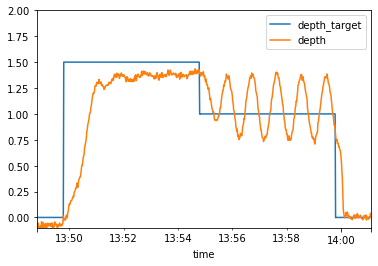

In [4]:
df_gen = sb.resample_join('1s',
                       bdata['mission']['depth'].rename('depth_target'),
                       bdata['depthFusion']['depth']
                      )
_ = df_gen.plot(ylim=(-.1, 2.))

---
## look at regulation

In [5]:
cfg['physics']

{'diam_collerette': 0.35,
 'g': 9.81,
 'm': 13.5,
 'piston_diameter': 0.0195,
 'piston_max_value': 1415.0,
 'piston_ref_eq': 1000.0,
 'piston_speed_max_tick': 20.0,
 'rho': 1020.0,
 'screw_thread': 8.48e-05,
 'tick_per_turn': 1.0}

In [6]:
cfg['regulation']['depth_controller']

{'delta_position_lb': 0.0,
 'delta_position_ub': 0.0,
 'delta_velocity_lb': 0.0,
 'delta_velocity_ub': 0.0,
 'divider_frequency': 5.0,
 'frequency': 25.0,
 'hold_depth_enable': False,
 'hold_depth_value_enter': 0.05,
 'hold_depth_value_exit': 0.0,
 'hysteresis_piston': 0.6,
 'limit_depth_controller': 0.2,
 'root_regulation': -0.5,
 'speed_volume_sink': 2.0}

---

## instantiate float object

In [7]:
ph = cfg['physics']
f = fl.autonomous_float(model='Ifremer', m=ph['m'])
f.init_piston()

print('tick_to_volume = {:.2e}'.format(f.piston.vol_increment))
print('volume available = {:.2e}'.format(f.piston.vol_max-f.piston.vol_min))
print('balast volume = {:.2e}'.format(f.piston.vol_increment*619.25))

Piston max volume set from max displacement
tick_to_volume = 2.56e-08
volume available = 2.69e-05
balast volume = 1.59e-05


In [8]:

#fl.regulation._control_feedback2?

### cognac lib 
# self._B = self.c1/(2*self.Lv*(1+self.a))
#
# seabot:
#  const double Cf = M_PI*pow(diam_collerette/2.0, 2);
#  tick_to_volume = (screw_thread/tick_per_turn)*pow(piston_diameter/2.0, 2)*M_PI;
#  coeff_A = g*rho/m;
#  coeff_B = 0.5*rho*Cf/m;
Cf = np.pi*(ph['diam_collerette']/2.)**2
B = 0.5*ph['rho']*Cf/ph['m']
A = ph['g']*ph['rho']/ph['m']
f.Lv = f.c1/(2*B*(1+f.a))

# regulation
r = cfg['regulation']['depth_controller']
#limit_velocity = 0.1 # from xml
#approach_velocity = 1. # from xml
limit_velocity = bdata['mission']['limit_velocity'].median()
approach_velocity = bdata['mission']['approach_velocity'].median()
root_regulation = r['root_regulation']

#ctrl = {'mode': 'feedback', 'dt': 5., 'dz_nochattering': 0.,
#      'nu': 2*target_velocity*2./np.pi, 'tau': 20., 'delta': .1,
#      'continuous': False}
ctrl = {'mode': 'feedback',
        'dt': 1/r['frequency'],
        'tau': 1/abs(root_regulation),  # Set the root of feed-back regulation # s assesed by simulation
        'nu': limit_velocity*2./np.pi, # Set the limit speed : 3cm/s assesed by simulation
        'delta': approach_velocity, #length scale that defines the zone of influence around the target depth, assesed by simulation
        'gamma': f.gamma, #mechanical compressibility [1/dbar]
        'rho_cte': ph['rho'],
         }

f.init_control(ctrl, f.v, ctrl['dt'])
print(f)

#def compute_u_f(f, z, dz, d2z, z_t, gamma):
#    return fl._control_feedback2(f.ctrl.lbd1, f.ctrl.lbd2, 
#                                 f.ctrl.nu, f.ctrl.delta, 
#                                 z, dz, d2z, z_t, gamma,
#                                 f.ctrl.A, f.ctrl.B)

f.ctrl

Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 13.50 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 1.06e+09 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 9.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the piston
  vol_increment  = 2.56e-02 cm^3      

Control parameters: 
  mode = feedback 
  dt = 4.00e-02 
  dz_nochattering = 0.00e+00 
  tau = 2.00e+00 
  nu = 6.37e-02 
  delta = 3.00e-01 
  continuous = 1.00e+00 

In [9]:
print('Number of ticks for 1 cm^3  : {:.1f} / dl={:.1e} mm'
      .format(1e-6/f.piston.vol_increment, 1e-6/f.piston.vol_increment*f.piston.d_increment*1e3, ))
print('Velocity for a 5g (={:.1f} ticks) difference : {:.1f} cm/s'
      .format(5*1e-6/f.piston.vol_increment, 
              1e2*f.get_drag_velocity(5e-3))
     )

Number of ticks for 1 cm^3  : 39.1 / dl=3.3e+00 mm
Velocity for a 5g (=195.3 ticks) difference : 2.2 cm/s


In [10]:
dt = '500ms'
dt = '1s'

df = sb.resample_join(dt,
                   bdata['kalman'][['velocity', 'depth', 'offset', 'chi', 'chi2', 'cz']],
                   bdata['pistonState']['position'],
                   bdata['mission']['depth'].rename('set_point'),
                   bdata['mission'][['limit_velocity','approach_velocity']]
                  )

df

,velocity,depth,offset,chi,chi2,cz,position,set_point,limit_velocity,approach_velocity
time,,,,,,,,,,
2020-06-18 13:49:20,-0.020211,-0.088446,0.000016,-6.413719e-16,0.000000e+00,1.000000,0.0,0.0,0.1,0.3
2020-06-18 13:49:21,0.009149,-0.071672,0.000016,-6.413719e-16,0.000000e+00,1.000000,0.0,0.0,0.1,0.3
2020-06-18 13:49:22,0.017155,-0.051848,0.000016,-6.413719e-16,0.000000e+00,1.000000,0.0,0.0,0.1,0.3
2020-06-18 13:49:23,0.011058,-0.068622,0.000016,-6.413719e-16,0.000000e+00,1.000000,0.0,0.0,0.1,0.3
2020-06-18 13:49:24,-0.044980,-0.112845,0.000016,-6.413719e-16,0.000000e+00,1.000000,0.0,0.0,0.1,0.3
...,...,...,...,...,...,...,...,...,...,...
2020-06-18 14:01:03,0.007247,-0.006100,0.000032,-6.735921e-08,-4.735700e-11,1.917955,1.0,0.0,0.0,1.0
2020-06-18 14:01:04,-0.009146,0.004575,0.000032,-6.735921e-08,-4.735700e-11,1.917955,1.0,0.0,0.0,1.0
2020-06-18 14:01:05,0.029737,0.039648,0.000032,-6.735921e-08,-4.735700e-11,1.917955,1.0,0.0,0.0,1.0


In [11]:
u = sb.compute_u(f, df, root_regulation, limit_velocity, approach_velocity)

In [12]:
df_u = sb.resample_join(dt, 
                     bdata['regulation']['u'].rename('u_bag'),
                     sum(u).rename('u_reconstructed'),
                     df['depth'],
                     *u
                    )
df_u = df_u[df_u['depth']>.1]

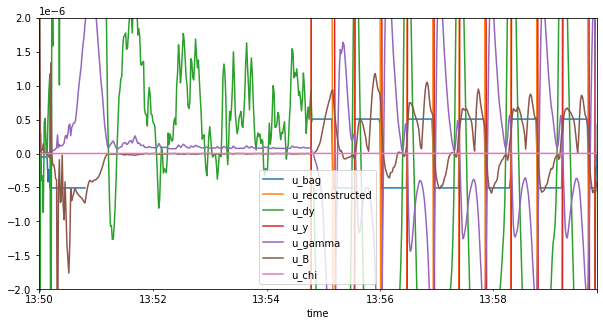

In [13]:
df_u.drop(columns='depth').plot(ylim=[-2e-6,2e-6], figsize=(10,5))

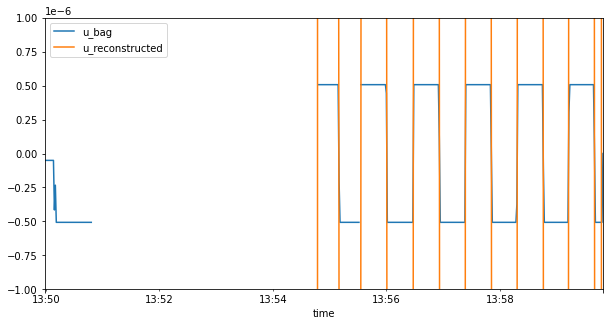

In [14]:
df_u[['u_bag', 'u_reconstructed']].plot(ylim=[-1e-6,1e-6], figsize=(10,5))

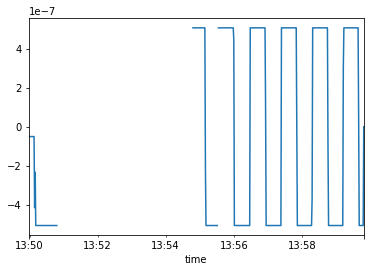

In [15]:
df_u['u_bag'].plot()

### detailed decomposition

In [16]:
U = sb.compute_u(f, df, root_regulation, limit_velocity, approach_velocity, decomposed=True)

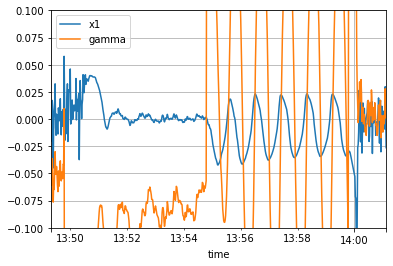

In [17]:
pd.concat(U['y'], axis=1).plot(grid=True, ylim=(-.1,.1))

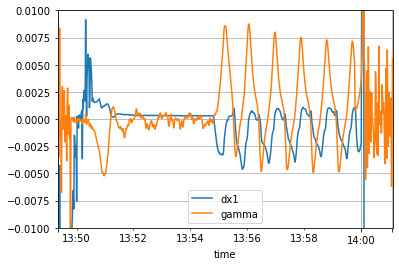

In [18]:
pd.concat(U['dy'], axis=1).plot(grid=True, ylim=(-.01,.01))

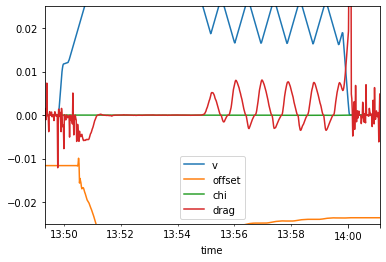

In [19]:
pd.concat(U['dx1'], axis=1).plot(ylim=(-.025,.025))

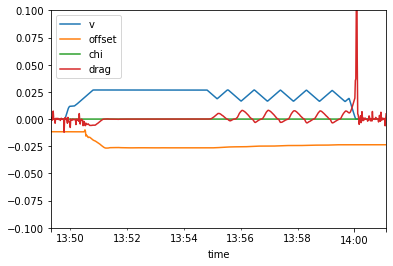

In [20]:
pd.concat(U['dx1'], axis=1).plot(ylim=(-.1,.1))